# Análisis COVID-19 en Colombia

Dada la coyuntura mundial que estamos viviendo, he decidido hacer un análisis sencillo de los casos de COVID-19 en Colombia.

La fuente de datos que uso es una URL JSON que tiene publicada el Instituto Nacional de Salud.  Esta fuente tiene el reporte detallado de cada caso y es actualizada al menos 2 veces al día.

La URL de la fuente de datos es: https://e.infogram.com/api/live/flex/bc384047-e71c-47d9-b606-1eb6a29962e3/664bc407-2569-4ab8-b7fb-9deb668ddb7a

Esta fuente de datos tiene varias particularidades:

- En ocasiones la estructura de datos no es la esperada.  Al parecer tienen problemas cuando la actualizan.
- El manejo de fecha de reporte, no tiene una estructura estándar. En ocasiones se devuelve como MM/DD/YYYY, pero en otras se devuelve como DD/MM/YYYY
- La columna Atención, Ciudades y País de procedencia tiene problemas de normalización, es decir, escriben el mismo dato de diferentes formas o con espacios al inicio o al final.


## Ingesta de datos

Los datos se obtienen directamente de la URL publicada por INS. Este es un archivo JSON.

In [257]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
from IPython.core.display import display, HTML

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [258]:
uri = 'https://e.infogram.com/api/live/flex/bc384047-e71c-47d9-b606-1eb6a29962e3/664bc407-2569-4ab8-b7fb-9deb668ddb7a'
resp = requests.get(uri)
txt = resp.json()
data = pd.DataFrame(txt['data'][0])
new_header = data.iloc[0] 
data = data[1:] 
data.columns = new_header
data.rename(columns={"Tipo*": "Tipo", "Atención**": "Atención", "Departamento o Distrito": "Departamento"}, inplace = True)

## Preparación de datos

Como lo mencionaba anteriormente, los datos llegan con problemas de formato y se debe arreglar para el correcto análisis

In [259]:
# Ajuste de formato de fechas
data['Fecha de diagnóstico'] = pd.to_datetime(data['Fecha de diagnóstico'], dayfirst=True) #, dayfirst=True
# Ajuste de columna Atención por uso de mayusculas mezcladas
data['Atención'] = data['Atención'].str.lower()
# Ajuste de columna Edad por elementos duplicados por dobles espacios
data['Edad'] = data['Edad'].replace('\s+', ' ', regex=True)
# Ajuste de columna Edad por elementos duplicados por dobles espacios y paises múltiples separados por guiones
data['País de procedencia'] = data['País de procedencia'].str.split('-').str[0].replace('\s+', ' ', regex=True)
data['País de procedencia'] = data['País de procedencia'].str.strip()
data.set_index('ID de caso', inplace=True)

Se cambia el tipo de datos de algunas columnas de manera categorica, para facilitar análisis posteriores

In [260]:
data['Sexo'] = data['Sexo'].astype('category')
data['Atención'] = data['Atención'].astype('category')
data['Tipo'] = data['Tipo'].astype('category')
data['Edad'] = data['Edad'].astype(int)

Se crean nuevas columnas para manejo categorico de las edades

In [261]:
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '>90']
data['rango_edades'] = pd.cut(data['Edad'], range(0,110,10), labels = labels)
labels = ['bebe', 'niño', 'adolescente', 'joven', 'adulto', 'adulto mayor']
data['tipo_edades'] = pd.cut(data['Edad'], [0, 6, 12, 19, 27, 60, 100], labels = labels)

Revisamos que la tabla ya este correctamente formada:

In [262]:
data.tail(5)

,Fecha de diagnóstico,Ciudad de ubicación,Departamento,Atención,Edad,Sexo,Tipo,País de procedencia,rango_edades,tipo_edades
ID de caso,,,,,,,,,,
1402,2020-04-04,Cali,Valle del Cauca,casa,29,F,Importado,0,20-29,adulto
1403,2020-04-04,Cali,Valle del Cauca,casa,40,M,En estudio,0,30-39,adulto
1404,2020-04-04,Cali,Valle del Cauca,casa,32,M,En estudio,0,30-39,adulto
1405,2020-04-04,Cali,Valle del Cauca,casa,41,M,Importado,0,40-49,adulto
1406,2020-04-04,Cali,Valle del Cauca,casa,45,F,Relacionado,0,40-49,adulto


## Exploración Inicial

A continuación, voy a mostrar algunas estadísticas básicas de los datos analizados:

In [264]:
conteo_casos_totales = len(data)
conteo_casos_departamentos = data['Departamento'].describe()['unique']
conteo_casos_ciudades = data['Ciudad de ubicación'].describe()['unique']

In [265]:
display(HTML('<h3>Número de casos: '+ str(conteo_casos_totales) +'</h3>'))
display(HTML('<h4>Departamentos afectados: '+ str(conteo_casos_departamentos) +'</h4>'))
display(HTML('<h4>Ciudades afectadas: '+ str(conteo_casos_ciudades) +'</h4>'))

## Análisis de datos

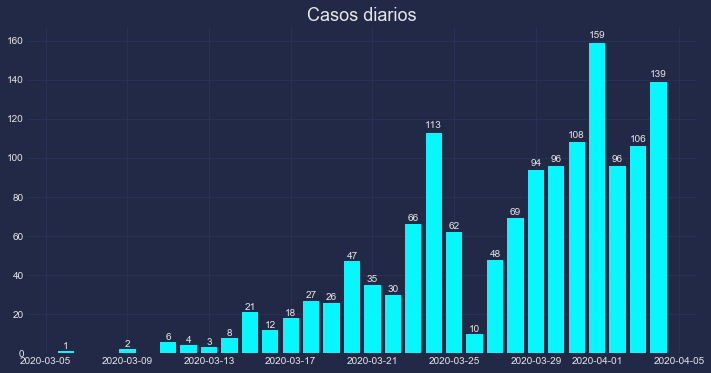

In [290]:
casos_x_fecha = data.groupby(['Fecha de diagnóstico']).size().fillna(0)
fig, ax = plt.subplots(figsize = (12,6))
plot = ax.bar(casos_x_fecha.index, casos_x_fecha)
plt.title('Casos diarios', fontsize=18)
for barra in plot:
    altura = barra.get_height()
    ax.text(barra.get_x() + barra.get_width()/2, 1.01*altura, int(altura), ha='center', va='bottom');

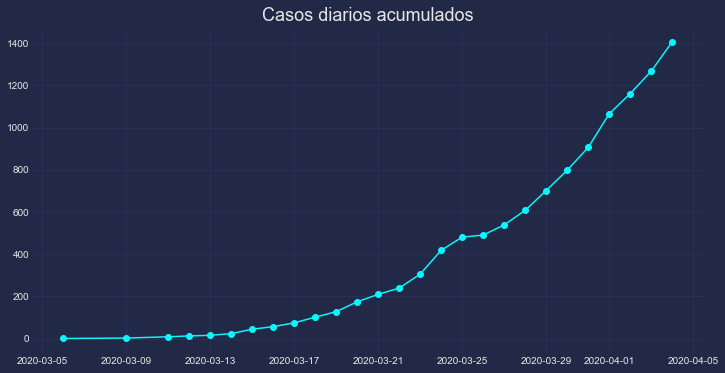

In [295]:
casos_x_fecha_acum = casos_x_fecha.cumsum()
fig, ax = plt.subplots(figsize = (12,6))
plot = plt.plot( casos_x_fecha_acum, linestyle='-', marker='o')
plt.title('Casos diarios acumulados', fontsize=18);

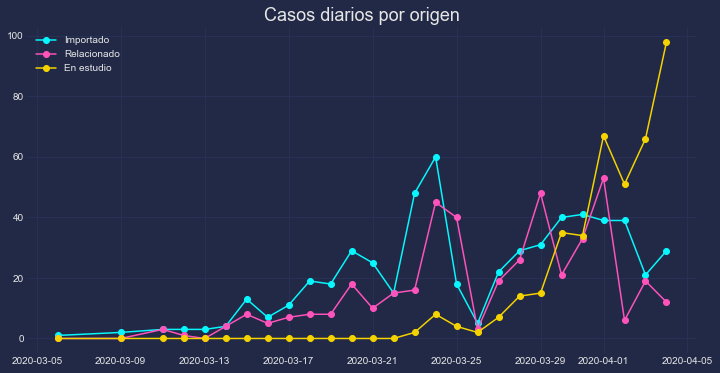

In [268]:
casos_x_fecha_tipo = data.groupby(['Fecha de diagnóstico','Tipo']).size().unstack('Tipo').fillna(0)
casos_x_fecha_tipo = casos_x_fecha_tipo.reindex(casos_x_fecha_tipo.sum().sort_values(ascending=False).index, axis=1)

plt.figure(figsize = (12,6))
plt.plot(casos_x_fecha_tipo, linestyle='-', marker='o')
plt.legend(casos_x_fecha_tipo.columns.tolist())
plt.title('Casos diarios por origen', fontsize=18);

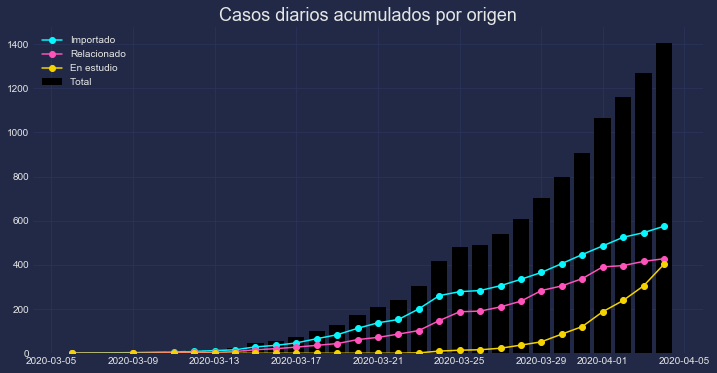

In [269]:
casos_x_fecha_tipo_acum = casos_x_fecha_tipo.cumsum()
plt.figure(figsize = (12,6))
plt.bar( casos_x_fecha_acum.index, casos_x_fecha_acum, color = 'black')
plt.plot( casos_x_fecha_tipo_acum, linestyle='-', marker='o')
plt.legend(casos_x_fecha_tipo_acum.columns.tolist() + ['Total'])
plt.title('Casos diarios acumulados por origen', fontsize=18);

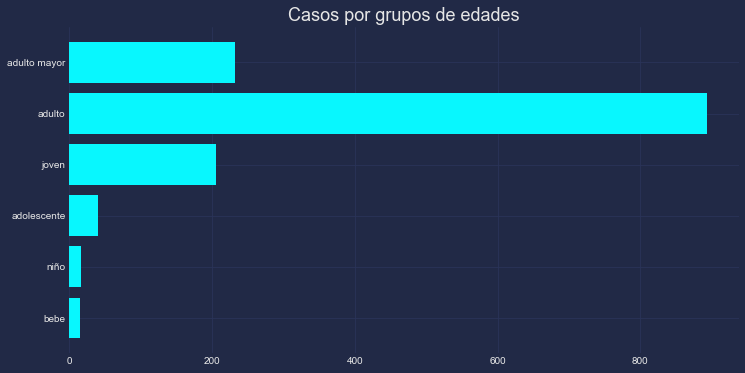

In [270]:
casos_x_edad = data.groupby('tipo_edades').size()
plt.figure(figsize = (12,6))
plt.barh(casos_x_edad.index, casos_x_edad)
plt.title('Casos por grupos de edades', fontsize=18);

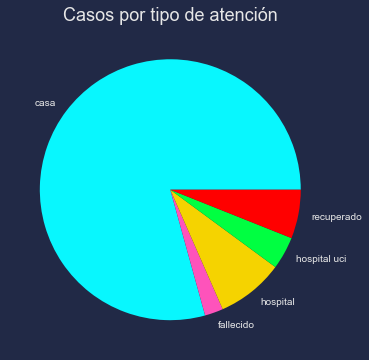

In [271]:
casos_x_atencion = data.groupby('Atención').size()
plt.figure(figsize = (12,6))
plt.pie(casos_x_atencion, labels = casos_x_atencion.index)
plt.title('Casos por tipo de atención', fontsize=18);

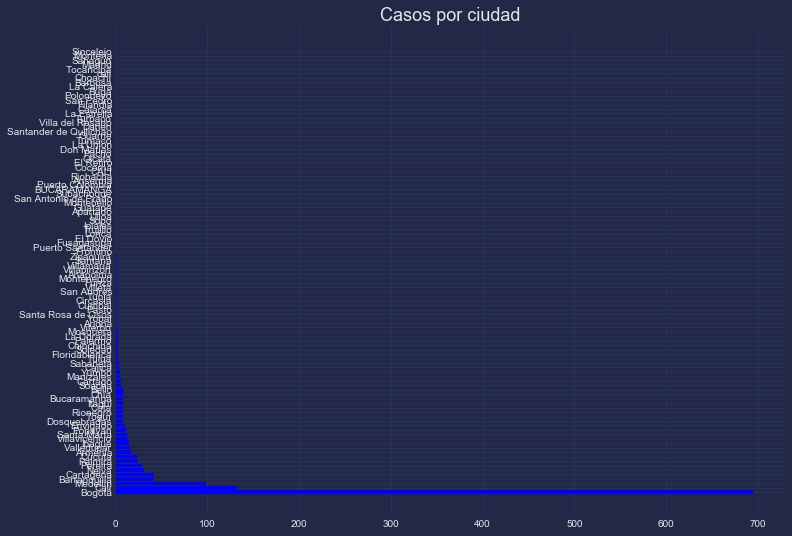

In [272]:
casos_x_ubicacion = data['Ciudad de ubicación'].value_counts()
plt.figure(figsize = (12,9))
plt.barh( casos_x_ubicacion.index, casos_x_ubicacion, color = 'blue')
plt.title('Casos por ciudad', fontsize=18);

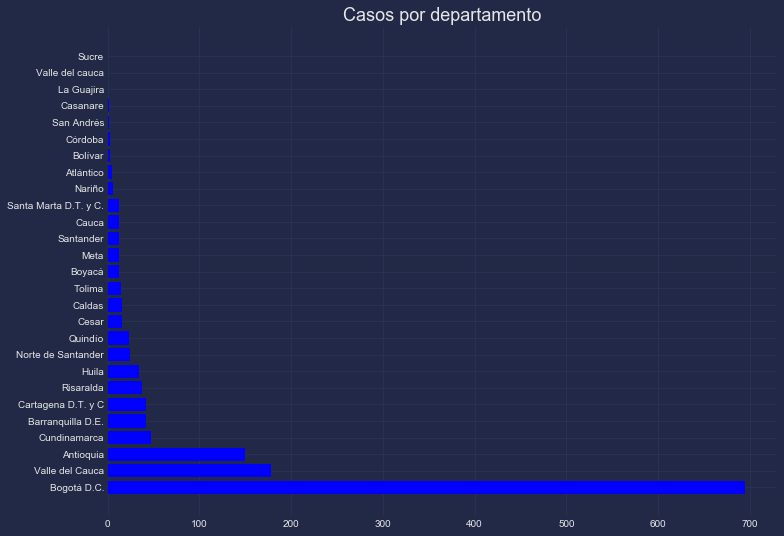

In [273]:
casos_x_departamento = data['Departamento'].value_counts()
plt.figure(figsize = (12,9))
plt.barh( casos_x_departamento.index, casos_x_departamento, color = 'blue')
plt.title('Casos por departamento', fontsize=18);

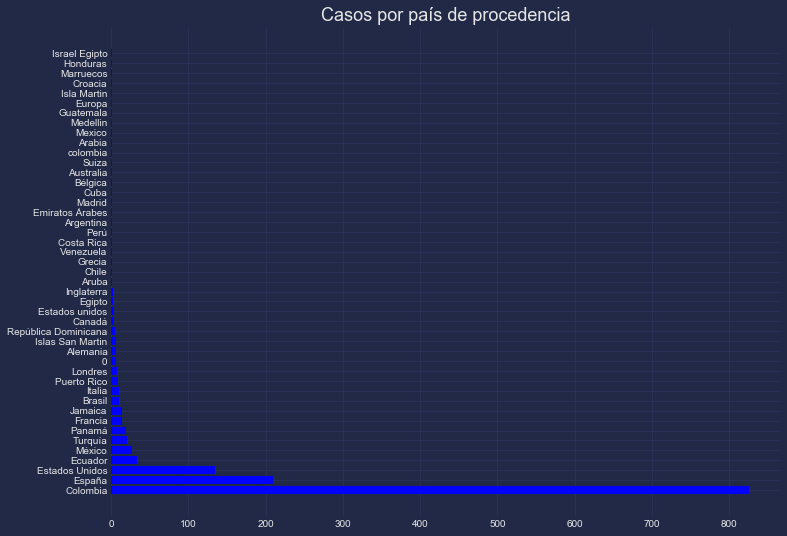

In [274]:
casos_x_pais = data['País de procedencia'].value_counts()
plt.figure(figsize = (12,9))
plt.barh( casos_x_pais.index, casos_x_pais, color = 'blue')
plt.title('Casos por país de procedencia', fontsize=18);

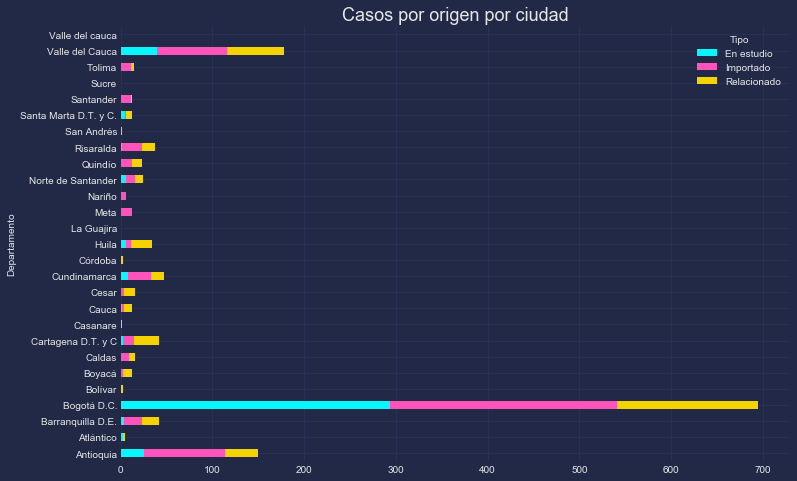

In [275]:
casos_x_departamento_tipo = data.groupby(['Departamento','Tipo']).size().unstack('Tipo').fillna(0)
casos_x_departamento_tipo.plot(kind = 'barh', stacked=True, figsize = (12,8))
plt.title('Casos por origen por ciudad', fontsize=18);

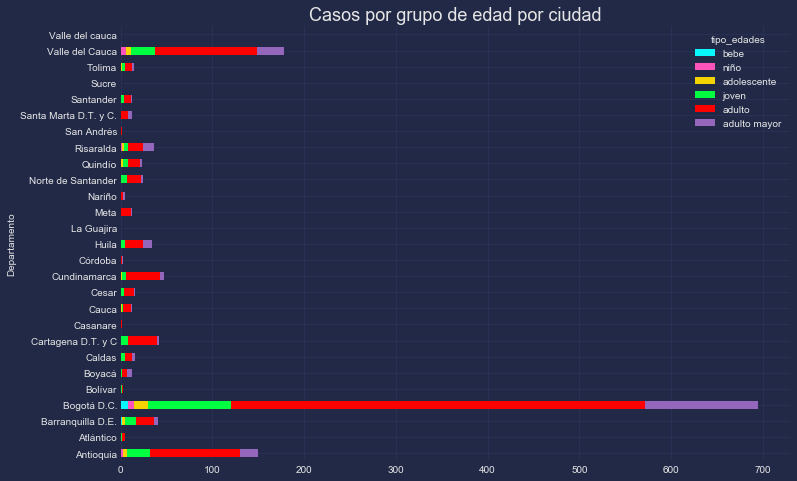

In [276]:
casos_x_departamento_edad = data.groupby(['Departamento','tipo_edades']).size().unstack('tipo_edades').fillna(0)
casos_x_departamento_edad.plot(kind = 'barh', stacked=True, figsize = (12,8))
plt.title('Casos por grupo de edad por ciudad', fontsize=18);

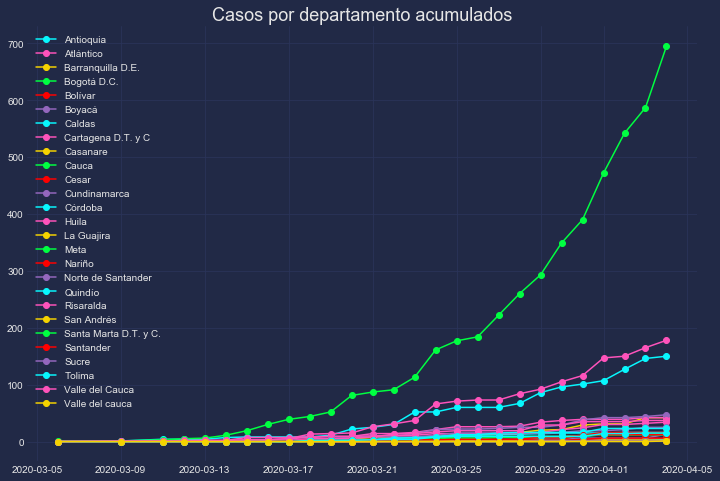

In [277]:
casos_x_fecha_departamento_acum = data.groupby(['Fecha de diagnóstico','Departamento']).size().unstack('Departamento').fillna(0).cumsum()
plt.figure(figsize = (12,8))
plt.plot(casos_x_fecha_departamento_acum, linestyle='-', marker='o' )
plt.legend(casos_x_fecha_departamento_acum.columns)
plt.title('Casos por departamento acumulados', fontsize=18);

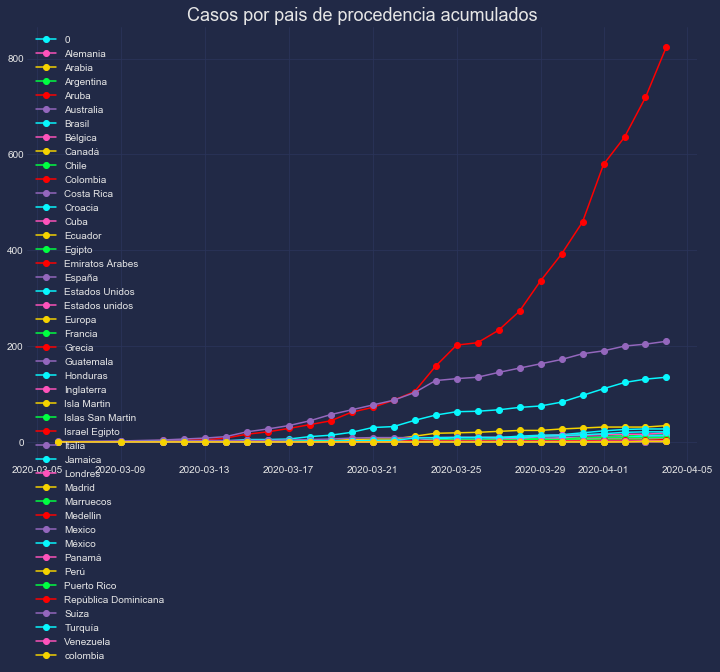

In [278]:
casos_x_fecha_procedencia_acum = data.groupby(['Fecha de diagnóstico','País de procedencia']).size().unstack('País de procedencia').fillna(0).cumsum()
plt.figure(figsize = (12,8))
plt.plot( casos_x_fecha_procedencia_acum, linestyle='-', marker='o')
plt.legend(casos_x_fecha_procedencia_acum.columns)
plt.title('Casos por pais de procedencia acumulados', fontsize=18);

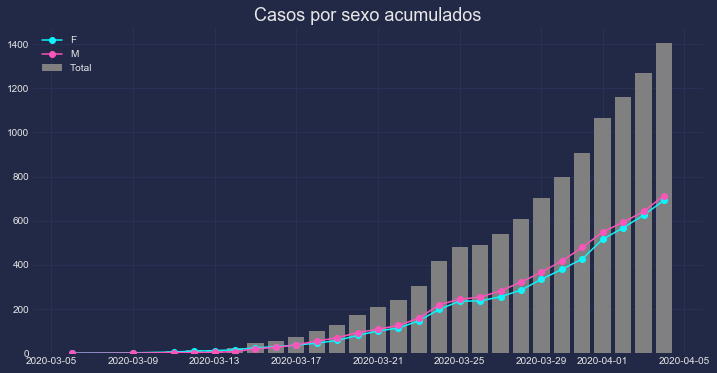

In [279]:
casos_x_fecha_sexo_acum = data.groupby(['Fecha de diagnóstico','Sexo']).size().unstack('Sexo').fillna(0).cumsum()

plt.figure(figsize = (12,6))
plt.bar( casos_x_fecha_acum.index, casos_x_fecha_acum, color = 'gray')
plt.plot( casos_x_fecha_sexo_acum, linestyle='-', marker='o')
plt.legend(casos_x_fecha_sexo_acum.columns.tolist() + ['Total'])
plt.title('Casos por sexo acumulados', fontsize=18);

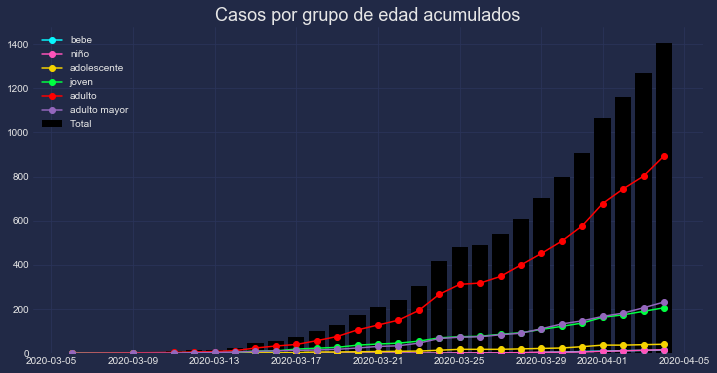

In [280]:
casos_x_fecha_edad_acum = data.groupby(['Fecha de diagnóstico','tipo_edades']).size().unstack('tipo_edades').fillna(0).cumsum()

plt.figure(figsize = (12,6))
plt.bar( casos_x_fecha_acum.index, casos_x_fecha_acum, color = 'black')
plt.plot( casos_x_fecha_edad_acum, linestyle='-', marker='o')
plt.legend(casos_x_fecha_edad_acum.columns.tolist() + ['Total'])
plt.title('Casos por grupo de edad acumulados', fontsize=18);

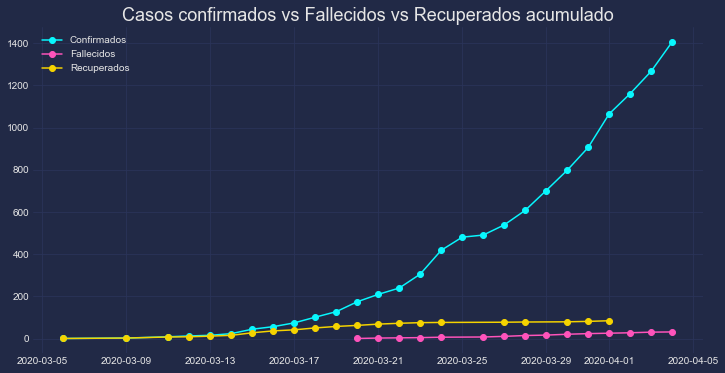

In [281]:
fallecidos_x_fecha = data[data['Atención'] == 'fallecido'].groupby(['Fecha de diagnóstico']).size().fillna(0)
fallecidos_x_fecha_acum = fallecidos_x_fecha.cumsum()

recuperados_x_fecha = data[data['Atención'] == 'recuperado'].groupby(['Fecha de diagnóstico']).size().fillna(0)
recuperados_x_fecha_acum = recuperados_x_fecha.cumsum()


plt.figure(figsize = (12,6))
plt.plot( casos_x_fecha_acum, linestyle='-', marker='o')
plt.plot( fallecidos_x_fecha_acum, linestyle='-', marker='o')
plt.plot( recuperados_x_fecha_acum, linestyle='-', marker='o')
plt.legend(['Confirmados', 'Fallecidos', 'Recuperados'])
plt.title('Casos confirmados vs Fallecidos vs Recuperados acumulado', fontsize=18);

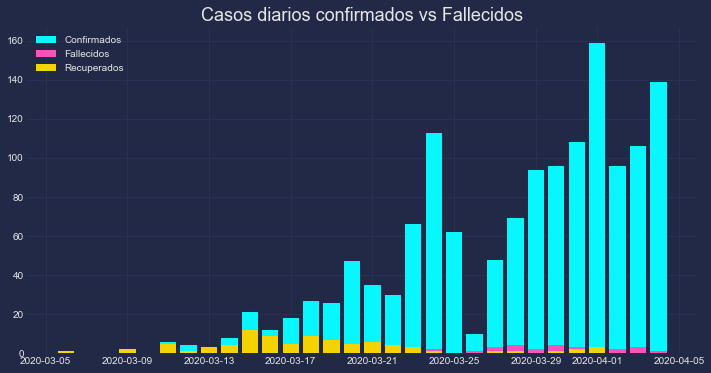

In [282]:
plt.figure(figsize = (12,6))
plt.bar( casos_x_fecha.index, casos_x_fecha);
plt.bar( fallecidos_x_fecha.index, fallecidos_x_fecha);
plt.bar( recuperados_x_fecha.index, recuperados_x_fecha);
plt.legend(['Confirmados', 'Fallecidos', 'Recuperados']);
plt.title('Casos diarios confirmados vs Fallecidos', fontsize=18);

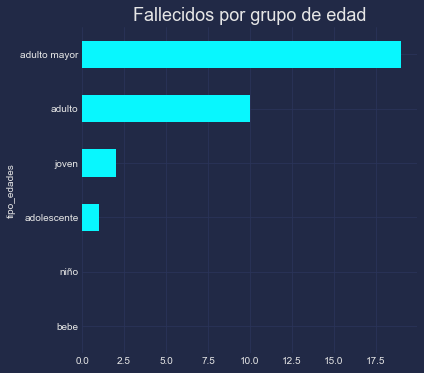

In [283]:
fallecidos_x_edad = data[data['Atención'] == 'fallecido'].groupby(['tipo_edades']).size()
fallecidos_x_edad.plot(kind = 'barh', figsize = (6, 6))
plt.title('Fallecidos por grupo de edad', fontsize=18);

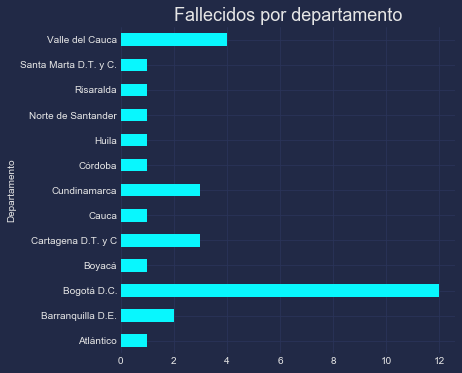

In [284]:
fallecidos_x_departamento = data[data['Atención'] == 'fallecido'].groupby(['Departamento']).size()
fallecidos_x_departamento.plot(kind = 'barh', figsize = (6, 6))
plt.title('Fallecidos por departamento', fontsize=18);

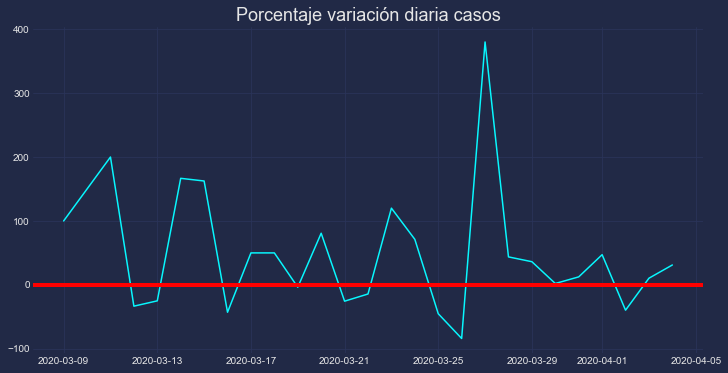

In [285]:
casos_change = data.groupby(['Fecha de diagnóstico']).size().pct_change(fill_method='ffill') * 100
plt.figure(figsize = (12,6))
plt.plot( casos_change)
plt.axhline(linewidth=4, color='r')
plt.title('Porcentaje variación diaria casos', fontsize=18);